# Data preparation

We combine the data, convert the labels for classification and apply augmentation

In [10]:
import os, sys, math, json
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

np.random.seed(0)

IMAGE_SIZE = [32, 32]

Tensorflow version 2.5.0


In [11]:
df = pd.read_json('../data/labelled_data/prepared-samples-binary.json')

y = df['label'].to_numpy()
X = np.array(df['data'].to_list())
X = np.expand_dims(X, axis=3)
print(y.shape)
print(X.shape)

(200,)
(200, 32, 32, 1)


In [12]:
# Create train / val / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [13]:
# Squeezenet Model

bnmomemtum=0.9

def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # input is 32x32 pixels RGB
y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(2, activation='softmax')(y)

model = tf.keras.Model(x, y)

model.compile(
optimizer='adam',
loss= 'sparse_categorical_crossentropy',
metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 32, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 32, 32, 32)   128         conv2d_16[0][0]                  
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 32)   0           batch_normalization_16[0][0]     
____________________________________________________________________________________________

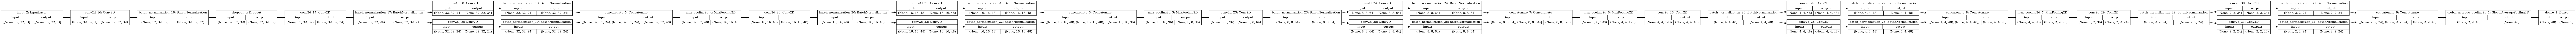

In [14]:
# Plot the model
# `rankdir='LR'` is to make the graph horizontal.
%matplotlib inline
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Epoch 1/50
8/8 [==============================] - 3s 97ms/step - loss: 0.6884 - accuracy: 0.5750 - val_loss: 0.7601 - val_accuracy: 0.3500
Epoch 2/50
8/8 [==============================] - 0s 50ms/step - loss: 0.6980 - accuracy: 0.5500 - val_loss: 0.7884 - val_accuracy: 0.3500
Epoch 3/50
8/8 [==============================] - 0s 49ms/step - loss: 0.6566 - accuracy: 0.5917 - val_loss: 0.7087 - val_accuracy: 0.4500
Epoch 4/50
8/8 [==============================] - 0s 48ms/step - loss: 0.6421 - accuracy: 0.6500 - val_loss: 0.6573 - val_accuracy: 0.5250
Epoch 5/50
8/8 [==============================] - 0s 60ms/step - loss: 0.6604 - accuracy: 0.5833 - val_loss: 0.6693 - val_accuracy: 0.5250
Epoch 6/50
8/8 [==============================] - 0s 63ms/step - loss: 0.6574 - accuracy: 0.6250 - val_loss: 0.6797 - val_accuracy: 0.5750
Epoch 7/50
8/8 [==============================] - 0s 51ms/step - loss: 0.5729 - accuracy: 0.6833 - val_loss: 0.6440 - val_accuracy: 0.6250
Epoch 8/50
8/8 [===========

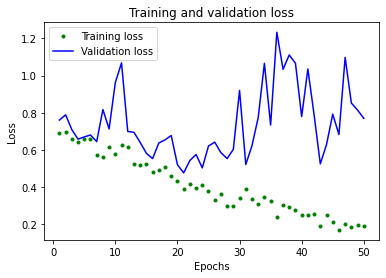

Test loss: 0.8761450052261353 / Test accuracy: 0.4749999940395355


In [15]:
# Fit the model
EPOCHS = 50
BATCH_SIZE = 16
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("squeezenet-eval.png")
plt.show()

# Generate generalization metrics
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [16]:
# make and show single prediciton
%matplotlib inline

n=4 # pics per row

label = {1: 'Human',
         0: 'No Human'}

pred = model.predict(X_test)

classes = np.argmax(pred, axis = 1)

print(classes)

[1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0
 1 1 1]


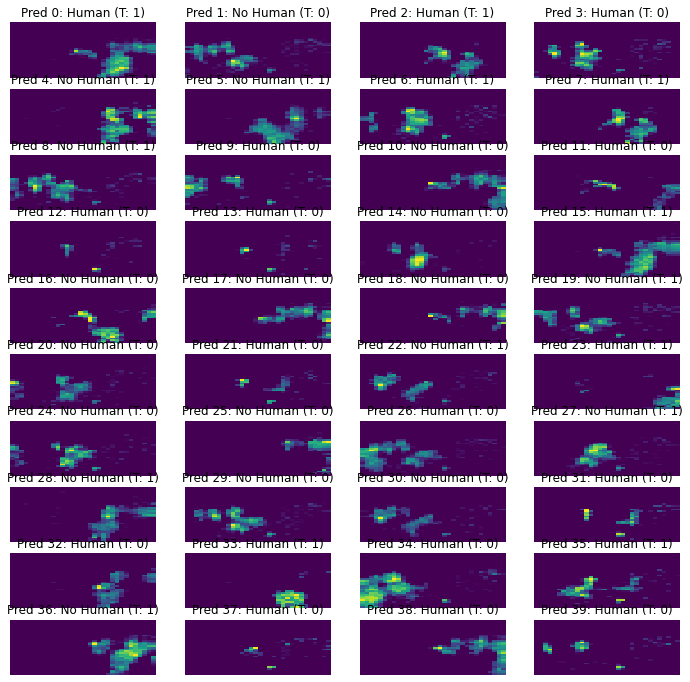

In [17]:
# Print predictions
fig, axes = plt.subplots(nrows=int(len(X_test)/n), ncols=n, figsize=(n*3, n*3), num='Predictions')
for ax, idx in zip(axes.reshape(-1), range(len(X_test))): 
    ax.set_axis_off()
    ax.set_title('Pred %i: %s (T: %i)' % (idx, label[classes[idx]], y_test[idx]))
    ax.imshow(X_test[idx].reshape(32, 32), interpolation='nearest', aspect='auto')

In [18]:
# Export saved model (h5 format)
tf.keras.models.save_model(model, "models/squeezenet-binary.h5")
# Export saved model (folder format) - needed for tflite!
tf.keras.models.save_model(model, "models/squeezenet-binary")

INFO:tensorflow:Assets written to: models/squeezenet-binary/assets
